# CBOW

Implement CBOW model. Idea is to use an `nn.Embedding` loookup table to extract word embedding, pass it through a linear layer, and implement a training

# Part 1: CBOW using `torch`

Use `torch` `nn.Module` to implement a CBOW model

In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import tiktoken
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Implement the `CBOW_torch` model

In [7]:
class CBOW_torch(nn.Module):
    def __init__(self, vocab_size, n_classes, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim

        self.token_embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        nn.init.xavier_normal_(self.token_embedding.weight)

        self.linear = nn.Linear(embedding_dim, n_classes)
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        # x shape: (B, seq_len) list of indices
        inp_embs = self.token_embedding(x) # (B, seq_len, emb_dim)
        linear_inp = inp_embs.sum(dim=1) # (B, emb_dim)
        logits = self.linear(linear_inp) # (B, num_classes)
        return logits

In [14]:
x = [1, 2 , 3]
x.extend([4, 5])
x

[1, 2, 3, 4, 5]

## Step 2: Prepare the data and dataloader

For starting, we do word level LM

In [41]:
label2id = {-1: 0, 0: 1, 1: 2}
id2label = {0: -1, 1: 0, 2: 1}

In [241]:
def create_word_level_data(file_path, mode=None):
    reviews, labels = [], []

    with open(file_path, 'r') as f:
        for line in f.read().splitlines():
            label, review = line.split("|||")
            review = review.strip()
            label = int(label.strip())
            reviews.append(review)
            labels.append(label2id[label])

    # if mode "train", create vocab array as well
    if mode != "train":
        return reviews, labels
    
    words = []
    for review in reviews:
        words.extend(review.split())

    unique_words = sorted(list(set(words)))

    word2id, id2word = {}, {}

    i = 0
    for word in unique_words:
        word2id[word] = i
        id2word[i] = word
        i += 1

    # add <unk> and <pad>
    word2id["<pad>"] = i
    id2word[i] = "<pad>"
    i += 1

    word2id["<unk>"] = i
    id2word[i] = "<unk>"
    i += 1

    return reviews, labels, word2id, id2word

In [242]:
train_reviews, train_labels, word2id, id2word = create_word_level_data("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/sst-sentiment-text-threeclass/train.txt", mode="train")
dev_reviews, dev_labels = create_word_level_data("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/sst-sentiment-text-threeclass/dev.txt")
test_reviews, test_labels = create_word_level_data("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/sst-sentiment-text-threeclass/test.txt")

In [243]:
len(train_reviews), len(train_labels)

(8544, 8544)

In [244]:
len(dev_reviews), len(dev_labels)

(1101, 1101)

In [245]:
len(test_reviews), len(test_labels)

(2210, 2210)

In [246]:
len(word2id)

18280

In [247]:
max([len(train_review.split()) for train_review in train_reviews])

52

In [248]:
def create_tensor_data(reviews, labels, word2id, seq_len):
    idx_list = []

    for review in reviews:
        words = review.split()
        words.extend(["<pad>"] * (seq_len - len(words)))
        idxs = [word2id[word] if word in word2id else word2id["<unk>"] for word in words]
        idx_list.append(idxs)

    torch_idxs = torch.LongTensor(idx_list)
    torch_labels = torch.LongTensor(labels)

    return torch_idxs, torch_labels

In [249]:
seq_len = 64
x_train, y_train = create_tensor_data(train_reviews, train_labels, word2id, seq_len)
x_dev, y_dev = create_tensor_data(dev_reviews, dev_labels, word2id, seq_len)
x_test, y_test = create_tensor_data(test_reviews, test_labels, word2id, seq_len)

In [250]:
x_train.shape, y_train.shape

(torch.Size([8544, 64]), torch.Size([8544]))

In [251]:
x_dev.shape, y_dev.shape

(torch.Size([1101, 64]), torch.Size([1101]))

In [252]:
x_test.shape, y_test.shape

(torch.Size([2210, 64]), torch.Size([2210]))

In [253]:
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

In [254]:
len(train_dataset)

8544

## Step 2: Write train function

In [146]:
def train(train_dataset, dev_dataset, model, batch_size, n_epochs, lr, loss=None):
    train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    dev_dataloder = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    if loss is None or loss=="cross entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss =="hinge":
        criterion = nn.MultiMarginLoss(margin=1.0, reduction="mean")
    metrics = []
    for epoch in range(n_epochs):
        # training loop
        model.train()
        train_loss = 0
        train_correct_count = 0
        for x, y in train_dataloder:
            optimizer.zero_grad()
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, y)
            pred_label = logits.argmax(dim=1)
            train_loss += loss.item() * x.shape[0]
            train_correct_count += (pred_label == y).sum()
            loss.backward()
            optimizer.step()

        # dev step
        model.eval()
        dev_loss = 0
        dev_correct_count = 0
        for x, y in dev_dataloder:
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, y)
            pred_label = logits.argmax(dim=1)
            dev_loss += loss.item() * x.shape[0]
            dev_correct_count += (pred_label == y).sum()

        train_loss = train_loss / len(train_dataset)
        train_acc = (train_correct_count / len(train_dataset)) * 100.00
        dev_loss = dev_loss / len(dev_dataset)
        dev_acc = (dev_correct_count / len(dev_dataset)) * 100.00
        metrics.append([train_loss, train_acc, dev_loss, dev_acc])

        if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} %, Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_acc:.2f} %")

    return np.array(metrics)


## Step 3: Train a model and test

### Word Level and NLL Loss

In [147]:
cbow_model_word_level_1 = CBOW_torch(vocab_size=len(word2id), n_classes=len(label2id), embedding_dim=128)

In [148]:
metrics1 = train(train_dataset, dev_dataset, model=cbow_model_word_level_1,\
      batch_size=128, n_epochs=50, lr=2e-5)

Epoch 1, Train Loss: 1.0888, Train Accuracy: 39.24 %, Dev Loss: 1.0542, Dev Accuracy: 44.78 %
Epoch 5, Train Loss: 0.9957, Train Accuracy: 60.17 %, Dev Loss: 1.0269, Dev Accuracy: 50.50 %
Epoch 10, Train Loss: 0.9381, Train Accuracy: 67.63 %, Dev Loss: 0.9961, Dev Accuracy: 58.76 %
Epoch 15, Train Loss: 0.8860, Train Accuracy: 69.78 %, Dev Loss: 0.9706, Dev Accuracy: 60.22 %
Epoch 20, Train Loss: 0.8376, Train Accuracy: 71.54 %, Dev Loss: 0.9487, Dev Accuracy: 61.22 %
Epoch 25, Train Loss: 0.7922, Train Accuracy: 72.81 %, Dev Loss: 0.9314, Dev Accuracy: 61.13 %
Epoch 30, Train Loss: 0.7489, Train Accuracy: 74.52 %, Dev Loss: 0.9155, Dev Accuracy: 61.94 %
Epoch 35, Train Loss: 0.7078, Train Accuracy: 76.36 %, Dev Loss: 0.9036, Dev Accuracy: 61.49 %
Epoch 40, Train Loss: 0.6688, Train Accuracy: 78.28 %, Dev Loss: 0.8938, Dev Accuracy: 61.40 %
Epoch 45, Train Loss: 0.6321, Train Accuracy: 80.29 %, Dev Loss: 0.8837, Dev Accuracy: 61.49 %
Epoch 50, Train Loss: 0.5971, Train Accuracy: 82.36 

In [149]:
metrics1.shape

(50, 4)

In [150]:
len(metrics1)

50

In [152]:
metrics1[:, 0].shape

(50,)

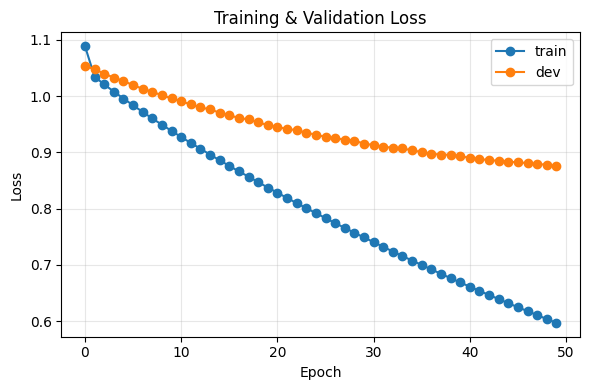

In [153]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 0], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 2], marker='o', label='dev')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

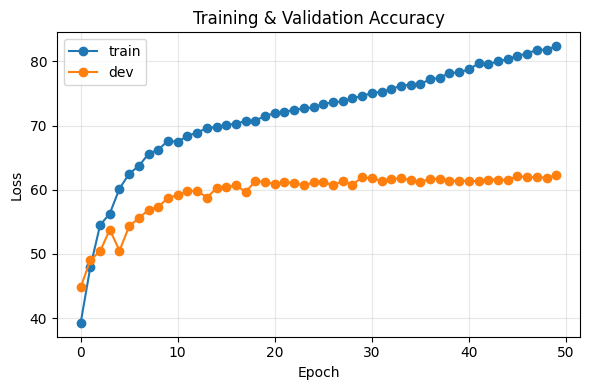

In [154]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 1], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 3], marker='o', label='dev')

plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

In [161]:
def get_test_metrics(test_dataset, model, loss=None):
    test_dataloder = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)
    if loss is None or loss=="cross entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss =="hinge":
        criterion = nn.MultiMarginLoss(margin=1.0, reduction="mean")
    
    model.eval()
    test_loss = 0
    test_correct_count = 0
    for x, y in test_dataloder:
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, y)
        pred_label = logits.argmax(dim=1)
        test_loss += loss.item() * x.shape[0]
        test_correct_count += (pred_label == y).sum()

    test_loss = test_loss / len(test_dataset)
    test_acc = (test_correct_count / len(test_dataset)) * 100.00
    return test_loss, test_acc

In [165]:
test_loss, test_acc = get_test_metrics(test_dataset, cbow_model_word_level_1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f} %")

Test Loss: 0.8324, Test Accuracy: 67.15 %


### Word Level and Hinge Loss

In [169]:
cbow_model_word_level_2 = CBOW_torch(vocab_size=len(word2id), n_classes=len(label2id), embedding_dim=128)

In [170]:
metrics1 = train(train_dataset, dev_dataset, model=cbow_model_word_level_2,\
      batch_size=128, n_epochs=50, lr=2e-5, loss="hinge")

Epoch 1, Train Loss: 0.6129, Train Accuracy: 39.00 %, Dev Loss: 0.5758, Dev Accuracy: 42.23 %
Epoch 5, Train Loss: 0.4922, Train Accuracy: 62.94 %, Dev Loss: 0.5268, Dev Accuracy: 57.31 %
Epoch 10, Train Loss: 0.4471, Train Accuracy: 67.52 %, Dev Loss: 0.5054, Dev Accuracy: 57.40 %
Epoch 15, Train Loss: 0.4045, Train Accuracy: 69.63 %, Dev Loss: 0.4858, Dev Accuracy: 59.58 %
Epoch 20, Train Loss: 0.3653, Train Accuracy: 71.43 %, Dev Loss: 0.4707, Dev Accuracy: 61.22 %
Epoch 25, Train Loss: 0.3299, Train Accuracy: 73.50 %, Dev Loss: 0.4595, Dev Accuracy: 61.49 %
Epoch 30, Train Loss: 0.2983, Train Accuracy: 75.66 %, Dev Loss: 0.4518, Dev Accuracy: 61.94 %
Epoch 35, Train Loss: 0.2693, Train Accuracy: 78.02 %, Dev Loss: 0.4478, Dev Accuracy: 61.76 %
Epoch 40, Train Loss: 0.2434, Train Accuracy: 80.37 %, Dev Loss: 0.4423, Dev Accuracy: 61.76 %
Epoch 45, Train Loss: 0.2200, Train Accuracy: 82.53 %, Dev Loss: 0.4394, Dev Accuracy: 62.03 %
Epoch 50, Train Loss: 0.1991, Train Accuracy: 84.84 

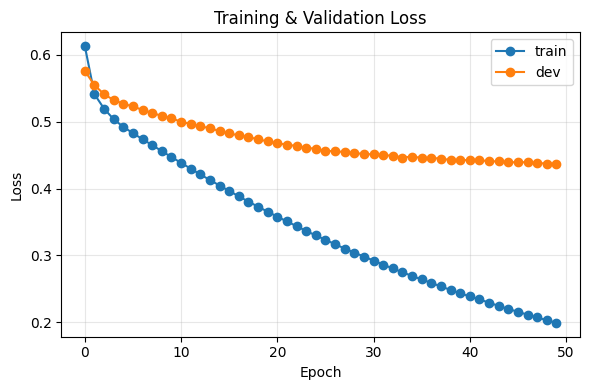

In [174]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 0], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 2], marker='o', label='dev')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

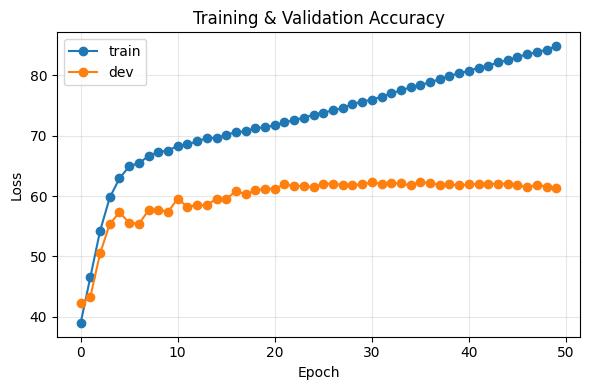

In [175]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 1], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 3], marker='o', label='dev')

plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

In [255]:
test_loss, test_acc = get_test_metrics(test_dataset, cbow_model_word_level_2, loss="hinge")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f} %")

Test Loss: 0.4093, Test Accuracy: 66.97 %


## Step 4: `tiktoken` tokenizer 

In [179]:
# GPT-2.
enc_gpt2 = tiktoken.get_encoding("gpt2")

In [182]:
vocab_size = enc_gpt2.n_vocab
vocab_size

50257

In [192]:
label2id

{-1: 0, 0: 1, 1: 2}

In [198]:
enc_gpt2.encode_batch(["hello", "hi", "my", "name is soham"])

[[31373], [5303], [1820], [3672, 318, 523, 2763]]

In [197]:
enc_gpt2.decode([31373, 23105, 616, 1438, 318, 523, 2763])

'hello hi my name is soham'

In [211]:
def create_token_level_data(file_path, encoder, seq_len):
    reviews, labels = [], []

    with open(file_path, 'r') as f:
        for line in f.read().splitlines():
            label, review = line.split("|||")
            review = review.strip()
            label = int(label.strip())
            reviews.append(review)
            labels.append(label2id[label])

    review_tokens = encoder.encode_batch(reviews)
    for i in range(len(review_tokens)):
        review_tokens[i].extend(list([50256]) * (seq_len - len(review_tokens[i])))

    torch_token_ids = torch.LongTensor(review_tokens)
    torch_labels = torch.LongTensor(labels)

    return torch_token_ids, torch_labels

In [212]:
x_train, y_train = create_token_level_data("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/sst-sentiment-text-threeclass/train.txt", encoder=enc_gpt2, seq_len=128)
x_dev, y_dev = create_token_level_data("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/sst-sentiment-text-threeclass/dev.txt", encoder=enc_gpt2, seq_len=128)
x_test, y_test = create_token_level_data("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/sst-sentiment-text-threeclass/test.txt", encoder=enc_gpt2, seq_len=128)

In [213]:
x_train.shape, y_train.shape

(torch.Size([8544, 128]), torch.Size([8544]))

In [214]:
x_dev.shape, y_dev.shape

(torch.Size([1101, 128]), torch.Size([1101]))

In [215]:
x_test.shape, y_test.shape

(torch.Size([2210, 128]), torch.Size([2210]))

In [216]:
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

### Token Level and NLL Loss

In [229]:
cbow_model_token_level_1 = CBOW_torch(vocab_size=vocab_size, n_classes=len(label2id), embedding_dim=128)

In [230]:
metrics1 = train(train_dataset, dev_dataset, model=cbow_model_token_level_1,\
      batch_size=128, n_epochs=50, lr=1e-5)

Epoch 1, Train Loss: 1.0982, Train Accuracy: 40.77 %, Dev Loss: 1.0590, Dev Accuracy: 42.78 %
Epoch 5, Train Loss: 1.0154, Train Accuracy: 55.24 %, Dev Loss: 1.0396, Dev Accuracy: 47.59 %
Epoch 10, Train Loss: 0.9788, Train Accuracy: 62.42 %, Dev Loss: 1.0198, Dev Accuracy: 53.68 %
Epoch 15, Train Loss: 0.9448, Train Accuracy: 66.68 %, Dev Loss: 0.9996, Dev Accuracy: 58.31 %
Epoch 20, Train Loss: 0.9132, Train Accuracy: 67.93 %, Dev Loss: 0.9847, Dev Accuracy: 57.67 %
Epoch 25, Train Loss: 0.8829, Train Accuracy: 69.32 %, Dev Loss: 0.9686, Dev Accuracy: 61.22 %
Epoch 30, Train Loss: 0.8550, Train Accuracy: 70.81 %, Dev Loss: 0.9553, Dev Accuracy: 60.76 %
Epoch 35, Train Loss: 0.8278, Train Accuracy: 71.51 %, Dev Loss: 0.9434, Dev Accuracy: 61.40 %
Epoch 40, Train Loss: 0.8018, Train Accuracy: 72.26 %, Dev Loss: 0.9330, Dev Accuracy: 61.58 %
Epoch 45, Train Loss: 0.7774, Train Accuracy: 73.02 %, Dev Loss: 0.9222, Dev Accuracy: 62.49 %
Epoch 50, Train Loss: 0.7534, Train Accuracy: 74.23 

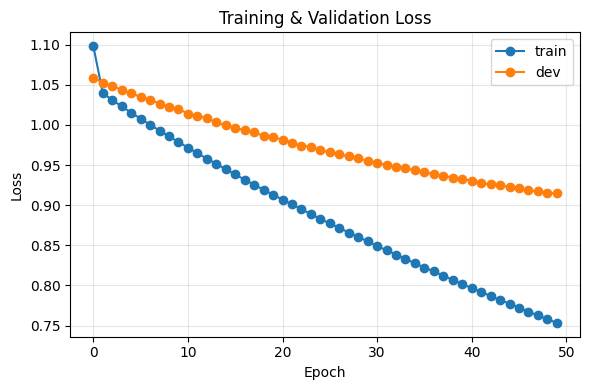

In [231]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 0], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 2], marker='o', label='dev')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

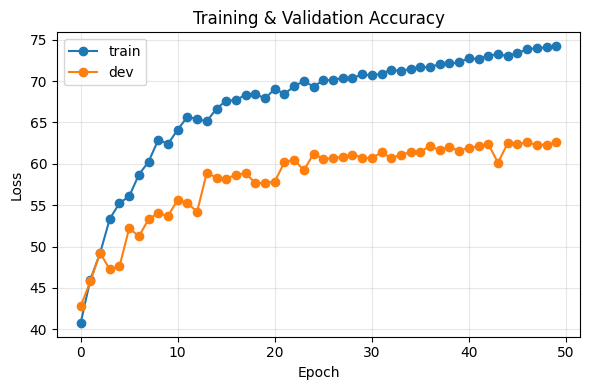

In [232]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 1], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 3], marker='o', label='dev')

plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

In [234]:
test_loss, test_acc = get_test_metrics(test_dataset, cbow_model_token_level_1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f} %")

Test Loss: 0.8835, Test Accuracy: 65.29 %


### Word Level and Hinge Loss

In [235]:
cbow_model_token_level_2 = CBOW_torch(vocab_size=vocab_size, n_classes=len(label2id), embedding_dim=128)

In [236]:
metrics1 = train(train_dataset, dev_dataset, model=cbow_model_token_level_2,\
      batch_size=128, n_epochs=50, lr=1e-5, loss="hinge")

Epoch 1, Train Loss: 0.7269, Train Accuracy: 24.73 %, Dev Loss: 0.6495, Dev Accuracy: 40.33 %
Epoch 5, Train Loss: 0.5096, Train Accuracy: 59.40 %, Dev Loss: 0.5351, Dev Accuracy: 54.22 %
Epoch 10, Train Loss: 0.4863, Train Accuracy: 65.82 %, Dev Loss: 0.5235, Dev Accuracy: 58.67 %
Epoch 15, Train Loss: 0.4638, Train Accuracy: 67.65 %, Dev Loss: 0.5119, Dev Accuracy: 61.31 %
Epoch 20, Train Loss: 0.4411, Train Accuracy: 68.73 %, Dev Loss: 0.5014, Dev Accuracy: 59.58 %
Epoch 25, Train Loss: 0.4184, Train Accuracy: 69.26 %, Dev Loss: 0.4905, Dev Accuracy: 60.85 %
Epoch 30, Train Loss: 0.3969, Train Accuracy: 70.19 %, Dev Loss: 0.4812, Dev Accuracy: 61.67 %
Epoch 35, Train Loss: 0.3766, Train Accuracy: 71.04 %, Dev Loss: 0.4718, Dev Accuracy: 63.31 %
Epoch 40, Train Loss: 0.3575, Train Accuracy: 72.06 %, Dev Loss: 0.4645, Dev Accuracy: 62.67 %
Epoch 45, Train Loss: 0.3392, Train Accuracy: 72.86 %, Dev Loss: 0.4588, Dev Accuracy: 62.49 %
Epoch 50, Train Loss: 0.3225, Train Accuracy: 74.18 

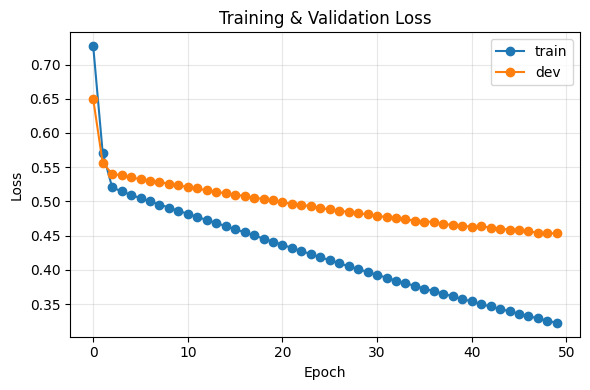

In [237]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 0], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 2], marker='o', label='dev')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

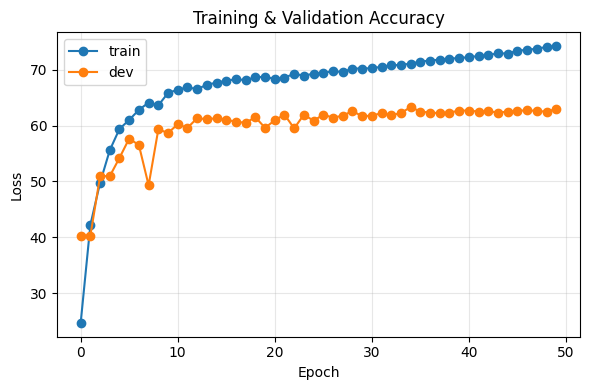

In [238]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(metrics1)), metrics1[:, 1], marker='o', label='train')
plt.plot(range(len(metrics1)), metrics1[:, 3], marker='o', label='dev')

plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

In [239]:
test_loss, test_acc = get_test_metrics(test_dataset, cbow_model_token_level_2, loss="hinge")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f} %")

Test Loss: 0.4272, Test Accuracy: 64.89 %


# Part 2: Deep CBOW using `torch`